In [1]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

from tsfm_public.toolkit.time_series_preprocessor import get_datasets

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback


/home/lsmo/anaconda3/envs/TTM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

df = pd.read_pickle('./RawData/New_campaigns/202403 SCOPE data set dynamic campaign.pkl')

df = df.dropna()

df['TI-1213'] = np.where(df['valve position'] == 1, df['TI-13'], df['TI-12'])

TARGETS_clean = ['AMP-4', 'PZ-4'] 

MEAS_COLUMNS = [ 'T-19', 'TI-3', 'F-19','F-11', 'TI-1213','TI-35']

df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])

for column in df.columns:
    if column != 'Date':
        df[column] = pd.to_numeric(df[column], errors='coerce')

float64


<Axes: xlabel='Date'>

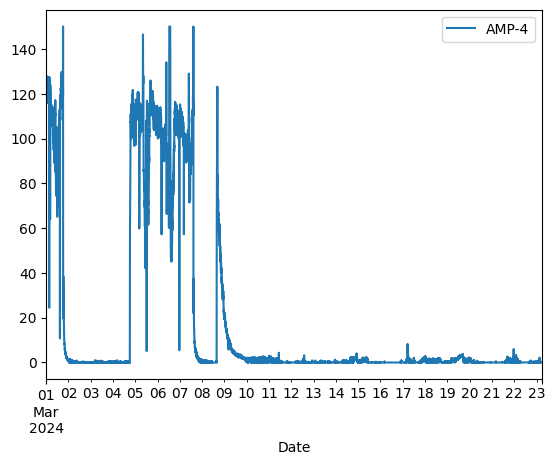

In [3]:
print(df['AMP-4'].dtypes)
df.plot(x='Date',y=TARGETS_clean[0])

In [3]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


timestamp_column = "Date"
id_columns = []
target_columns = [TARGETS_clean[0]] + MEAS_COLUMNS
split_config = {
                        'train': 0.7,
                        'test': 0.3
                    }


column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    ts_preprocessor=tsp, dataset=df, split_config=split_config, fewshot_fraction=None, fewshot_location="first"
)

print(len(df))
print(len(train_dataset)+len(valid_dataset)+len(test_dataset))
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

192241
191539
Data lengths: train = 133961, val = 1, test = 57577


In [18]:
test_dataset.group_df

In [4]:
TTM_MODEL_REVISION = "main"

zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)

In [5]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [6]:
# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_output = zeroshot_trainer.evaluate(test_dataset)
print(zeroshot_output)



++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


100%|██████████| 900/900 [03:03<00:00,  4.90it/s]

{'eval_loss': 0.3423871099948883, 'eval_runtime': 184.0741, 'eval_samples_per_second': 312.793, 'eval_steps_per_second': 4.889}


In [ ]:
plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(temp_dir), plot_prefix="test_zeroshot", channel=0)
# plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join('./', "ettm2"), plot_prefix="test_zeroshot", channel=0)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

zeroshot_trainer.model = zeroshot_trainer.model.to(device)
test_dataset = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(device=device)
output = zeroshot_trainer.model(test_dataset)

KeyError: 0